In [23]:
library(gmnl)
library(mlogit)
library(AER)
library(plyr)

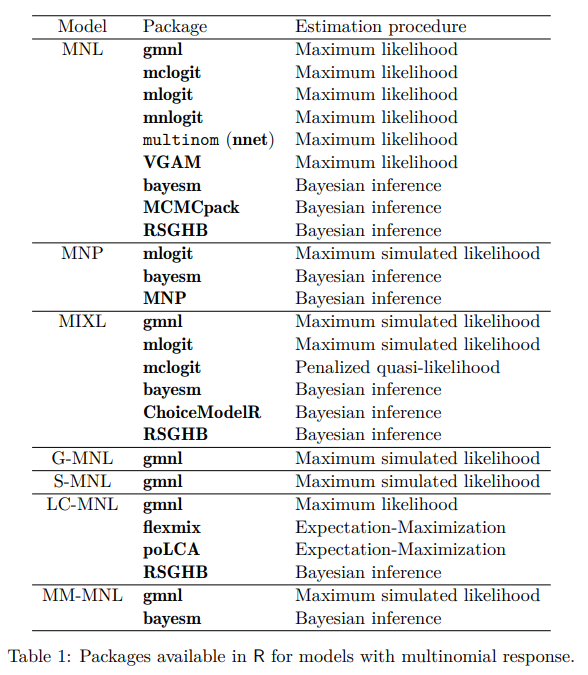

# Mixed Logit Model

## TravelMode

In [14]:
data("TravelMode", package = "AER")
head(TravelMode)

,individual,mode,choice,wait,vcost,travel,gcost,income,size
,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,air,no,69,59,100,70,35,1
2,1,train,no,34,31,372,71,35,1
3,1,bus,no,35,25,417,70,35,1
4,1,car,yes,0,10,180,30,35,1
5,2,air,no,64,58,68,68,30,2
6,2,train,no,44,31,354,84,30,2


In [18]:
with(TravelMode, prop.table(table(mode[choice == "yes"])))


      air     train       bus       car 
0.2761905 0.3000000 0.1428571 0.2809524 

In [21]:
# long to wide
wide_TM <- reshape(TravelMode, idvar = c("individual", "income", "size"), timevar = "mode", direction = "wide")
wide_TM$chosen_mode[wide_TM$choice.air == "yes"] <- "air"
wide_TM$chosen_mode[wide_TM$choice.car == "yes"] <- "car"
wide_TM$chosen_mode[wide_TM$choice.train == "yes"] <- "train"
wide_TM$chosen_mode[wide_TM$choice.bus == "yes"] <- "bus"
head(wide_TM)

,individual,income,size,choice.air,wait.air,vcost.air,travel.air,gcost.air,choice.train,wait.train,⋯,wait.bus,vcost.bus,travel.bus,gcost.bus,choice.car,wait.car,vcost.car,travel.car,gcost.car,chosen_mode
,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<int>,⋯,<int>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<chr>
1,1,35,1,no,69,59,100,70,no,34,⋯,35,25,417,70,yes,0,10,180,30,car
5,2,30,2,no,64,58,68,68,no,44,⋯,53,25,399,85,yes,0,11,255,50,car
9,3,40,1,no,69,115,125,129,no,34,⋯,35,53,882,149,yes,0,23,720,101,car
13,4,70,3,no,64,49,68,59,no,44,⋯,53,21,399,81,yes,0,5,180,32,car
17,5,45,2,no,64,60,144,82,no,44,⋯,53,26,449,94,yes,0,8,600,99,car
21,6,20,1,no,69,59,100,70,yes,40,⋯,35,13,417,58,no,0,12,284,43,train


In [24]:
ddply(wide_TM, ~ chosen_mode, summarize, mean.income = mean(income))

chosen_mode,mean.income
<chr>,<dbl>
air,41.72414
bus,29.70000
car,42.22034
train,23.06349


## model

In [16]:
TM <- mlogit.data(TravelMode, choice = "choice", shape = "long", alt.levels = c("air", "train", "bus", "car"))
mixl <- gmnl(choice ~ vcost + travel + wait | 1, data = TM, model = "mixl", ranp = c(travel = "n"), R = 50)

Estimating MIXL model 


In [17]:
summary(mixl)


Model estimated on: 土 12月 28 17時05分13秒 2019 

Call:
gmnl(formula = choice ~ vcost + travel + wait | 1, data = TM, 
    model = "mixl", ranp = c(travel = "n"), R = 50, method = "bfgs")

Frequencies of categories:

    air   train     bus     car 
0.27619 0.30000 0.14286 0.28095 

The estimation took: 0h:0m:4s 

Coefficients:
                    Estimate Std. Error z-value  Pr(>|z|)    
train:(intercept)  0.3613125  1.0101362  0.3577 0.7205776    
bus:(intercept)   -0.4468465  1.0393611 -0.4299 0.6672507    
car:(intercept)   -4.9045317  1.0931853 -4.4865 7.242e-06 ***
vcost             -0.0261113  0.0095413 -2.7366 0.0062069 ** 
wait              -0.1164241  0.0148425 -7.8439 4.441e-15 ***
travel            -0.0080832  0.0023610 -3.4236 0.0006179 ***
sd.travel          0.0053101  0.0020409  2.6019 0.0092721 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Optimization of log-likelihood by BFGS maximization
Log Likelihood: -189.11
Number of observations: 210
Numbe

# Latent Class Logit Model

## Electricity

In [27]:
data("Electricity", package = "mlogit")
Electr <- mlogit.data(Electricity, id.var = "id", choice = "choice", 
                      varying = 3:26, shape = "wide", sep = "")
head(Electr)

,choice,id,alt,pf,cl,loc,wk,tod,seas,chid
,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1.1,FALSE,1,1,7,5,0,1,0,0,1
1.2,FALSE,1,2,9,1,1,0,0,0,1
1.3,FALSE,1,3,0,0,0,0,0,1,1
1.4,TRUE,1,4,0,5,0,1,1,0,1
2.1,FALSE,1,1,7,0,0,1,0,0,2
2.2,FALSE,1,2,9,5,0,1,0,0,2


電力契約選択肢4つ  
* pf: 固定価格  
* cl: 契約期間
* loc: ローカル
* wk: よく知っている
* tod: 時刻レート
* seas: 季節レート

In [28]:
Electr$asc2 <- as.numeric(Electr$alt == 2)
Electr$asc3 <- as.numeric(Electr$alt == 3)
Electr$asc4 <- as.numeric(Electr$alt == 4)

## model

In [34]:
Elec.lc <- gmnl(choice ~ pf + cl + loc + wk + tod + seas | 0 | 0 | 0 | 1, 
                data = Electr, subset = 1:3000, model = 'lc', panel = TRUE, Q = 2)

Estimating LC model 


In [35]:
summary(Elec.lc)


Model estimated on: 土 12月 28 19時31分56秒 2019 

Call:
gmnl(formula = choice ~ pf + cl + loc + wk + tod + seas | 0 | 
    0 | 0 | 1, data = Electr, subset = 1:3000, model = "lc", 
    Q = 2, panel = TRUE, method = "bfgs")

Frequencies of categories:

      1       2       3       4 
0.21467 0.30267 0.21733 0.26533 

The estimation took: 0h:0m:0s 

Coefficients:
              Estimate Std. Error  z-value  Pr(>|z|)    
class.1.pf   -0.445822   0.087567  -5.0912 3.557e-07 ***
class.1.cl   -0.184654   0.030077  -6.1393 8.288e-10 ***
class.1.loc   1.214376   0.161829   7.5041 6.195e-14 ***
class.1.wk    0.964074   0.142875   6.7477 1.502e-11 ***
class.1.tod  -3.218417   0.687990  -4.6780 2.897e-06 ***
class.1.seas -3.486496   0.692898  -5.0318 4.860e-07 ***
class.2.pf   -0.843079   0.096787  -8.7107 < 2.2e-16 ***
class.2.cl   -0.124183   0.045291  -2.7419  0.006109 ** 
class.2.loc   1.644477   0.268852   6.1167 9.555e-10 ***
class.2.wk    1.413870   0.211971   6.6701 2.556e-11 ***
class.2.tod